# Working With COG

For this demo we will use the new `Ozone Monitoring Instrument (OMI) / Aura NO2 Tropospheric Column Density` dataset hosted on AWS PDS: https://registry.opendata.aws/omi-no2-nasa/


#### Requirements
- AWS credentials
- rasterio
- ipyleaflet
- requests
- tqdm

`pip install rasterio[s3] ipyleaflet requests tqdm`

In [108]:
import os
import json
import urllib.parse
from io import BytesIO
from functools import partial
from concurrent import futures

import requests

from boto3.session import Session as boto3_session

from rasterio.plot import reshape_as_image
from rasterio.features import bounds as featureBounds

from tqdm.notebook import tqdm

from ipyleaflet import Map, basemaps, TileLayer, basemap_to_tiles

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [47]:
titiler_endpoint = "https://dfu60xgk3j.execute-api.us-east-1.amazonaws.com/"  # Devseed temporary endpoint

## Define your area of interest (AOI)

In [110]:
# use geojson.io
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -74.1796875,
              45.18978009667531
            ],
            [
              -73.092041015625,
              45.18978009667531
            ],
            [
              -73.092041015625,
              46.00459325574482
            ],
            [
              -74.1796875,
              46.00459325574482
            ],
            [
              -74.1796875,
              45.18978009667531
            ]
          ]
        ]
      }
    }
  ]
}

bounds = featureBounds(geojson)

In [49]:
Map(
    basemap=basemaps.OpenStreetMap.Mapnik,
    center=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom=6
)

Map(center=[45.597186676210065, -73.6358642578125], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## List available files on AWS S3

In [50]:
session = boto3_session(region_name="us-west-2")
client = session.client("s3")

bucket = "omi-no2-nasa"  #https://registry.opendata.aws/omi-no2-nasa/


def list_objects(bucket, prefix):
    """AWS s3 list objects."""

    paginator = client.get_paginator('list_objects_v2')

    files = []
    for subset in paginator.paginate(Bucket=bucket, Prefix=prefix):
        files.extend(subset.get("Contents", []))

    return [r["Key"] for r in files]

files = list_objects(bucket, "OMI-Aura_L3")
print(f"Found : {len(files)}")

Found : 5688


In [51]:
print(files[0:10])

['OMI-Aura_L3-OMNO2d_2004m1001_v003-2019m1121t082956.tif', 'OMI-Aura_L3-OMNO2d_2004m1002_v003-2019m1120t150658.tif', 'OMI-Aura_L3-OMNO2d_2004m1003_v003-2019m1121t083143.tif', 'OMI-Aura_L3-OMNO2d_2004m1004_v003-2019m1120t150808.tif', 'OMI-Aura_L3-OMNO2d_2004m1005_v003-2019m1121t083127.tif', 'OMI-Aura_L3-OMNO2d_2004m1006_v003-2019m1120t150704.tif', 'OMI-Aura_L3-OMNO2d_2004m1007_v003-2019m1120t150647.tif', 'OMI-Aura_L3-OMNO2d_2004m1008_v003-2019m1121t082954.tif', 'OMI-Aura_L3-OMNO2d_2004m1009_v003-2019m1120t152036.tif', 'OMI-Aura_L3-OMNO2d_2004m1010_v003-2019m1121t083226.tif']


file name structure is `"OMI-Aura_L3-OMNO2d_{YEAR}m{MONTH:02}{DAY:02}..."`

We can then easily filter e.g 

In [52]:
files_2019 = list(filter(lambda x: x.split("_")[2][0:4] == "2019", files))
print(len(files_2019))

365


In [53]:
files_Oct5 = list(filter(lambda x: (x.split("_")[2][5:7] == "10") & (x.split("_")[2][7:9] == "05"), files))
print(len(files_Oct5))
print(files_Oct5)

16
['OMI-Aura_L3-OMNO2d_2004m1005_v003-2019m1121t083127.tif', 'OMI-Aura_L3-OMNO2d_2005m1005_v003-2019m1120t222137.tif', 'OMI-Aura_L3-OMNO2d_2006m1005_v003-2019m1121t041524.tif', 'OMI-Aura_L3-OMNO2d_2007m1005_v003-2019m1121t101933.tif', 'OMI-Aura_L3-OMNO2d_2008m1005_v003-2019m1121t164133.tif', 'OMI-Aura_L3-OMNO2d_2009m1005_v003-2019m1121t211205.tif', 'OMI-Aura_L3-OMNO2d_2010m1005_v003-2019m1122t022154.tif', 'OMI-Aura_L3-OMNO2d_2011m1005_v003-2019m1122t054850.tif', 'OMI-Aura_L3-OMNO2d_2012m1005_v003-2019m1122t075810.tif', 'OMI-Aura_L3-OMNO2d_2013m1005_v003-2019m1122t125824.tif', 'OMI-Aura_L3-OMNO2d_2014m1005_v003-2019m1122t164301.tif', 'OMI-Aura_L3-OMNO2d_2015m1005_v003-2019m1122t203759.tif', 'OMI-Aura_L3-OMNO2d_2016m1005_v003-2019m1123t024953.tif', 'OMI-Aura_L3-OMNO2d_2017m1005_v003-2019m1123t050945.tif', 'OMI-Aura_L3-OMNO2d_2018m1005_v003-2019m1123t090601.tif', 'OMI-Aura_L3-OMNO2d_2019m1005_v003-2020m0428t113315.tif']


### DATA Endpoint

`{endpoint}/cog/tiles/{z}/{x}/{y}.{format}?url={cog}&{otherquery params}`


`{endpoint}/cog/crop/{minx},{miny},{maxx},{maxy}.{format}?url={cog}&{otherquery params}`


`{endpoint}/cog/point/{minx},{miny}?url={cog}&{otherquery params}`


### Visualize One Item

In [ ]:
def _url(src_path):
    return f"s3://omi-no2-nasa/{src_path}"

In [166]:
# Fetch File Metadata to get min/max rescaling values (because the file is stored as float32)

r = requests.get(
    f"{titiler_endpoint}/cog/metadata",
    params = {
        "url": _url(files[0]),
        "pmin": 20,
        "pmax": 98,
    }
).json()

print(json.dumps(r, indent=4))

{
    "bounds": [
        -180.0,
        -90.0,
        180.0,
        90.0
    ],
    "band_metadata": [
        [
            1,
            {}
        ]
    ],
    "band_descriptions": [
        [
            1,
            "ColumnAmountNO2TropCloudScreened"
        ]
    ],
    "dtype": "float32",
    "colorinterp": [
        "gray"
    ],
    "nodata_type": "Nodata",
    "statistics": {
        "1": {
            "pc": [
                -25179359019008.0,
                2655721033092300.5
            ],
            "min": -1.1083295177572352e+16,
            "max": 7.240744489399091e+16,
            "std": 1005013765073387.9,
            "histogram": [
                [
                    153.0,
                    361369.0,
                    1785.0,
                    206.0,
                    27.0,
                    12.0,
                    3.0,
                    0.0,
                    0.0,
                    1.0
                ],
                [
              

In [109]:
r = requests.get(
    f"{titiler_endpoint}/cog/tilejson.json",
    params = {
        "url": _url(files[2]),
        "rescale": "0,3000000000000000",
        "color_map": "viridis",
    }
).json()

m = Map(
    center=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom=6
)

aod_layer = TileLayer(
    url=r["tiles"][0],
    opacity=1
)
m.add_layer(aod_layer)
m

Map(center=[45.597186676210065, -73.6358642578125], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### Create time series of NO2

In [185]:
def _stats(data, mask):
    arr = numpy.ma.array(data)
    arr.mask = mask == 0
    return arr.min().item(), arr.max().item(), arr.mean().item(), arr.std().item()


xmin, ymin, xmax, ymax = bounds

def fetch_bbox(file):
    url = f"{titiler_endpoint}cog/crop/{xmin},{ymin},{xmax},{ymax}.npy"
    params = {
        "url": _url(file),
        "bidx": "1",
        "max_size": 128,
    }
    r = requests.get(url, params=params)
    data, mask = numpy.load(BytesIO(r.content), allow_pickle=True)
    s = _stats(data, mask)
    return s[1], file.split("_")[2]


In [212]:
def _filter_futures(tasks):
    for future in tasks:
        try:
            yield future.result()
        except Exception:
            pass


In [214]:
# Every 15 of each month for all the years
files_15 = list(filter(lambda x: (x.split("_")[2][7:9] == "15"), files))

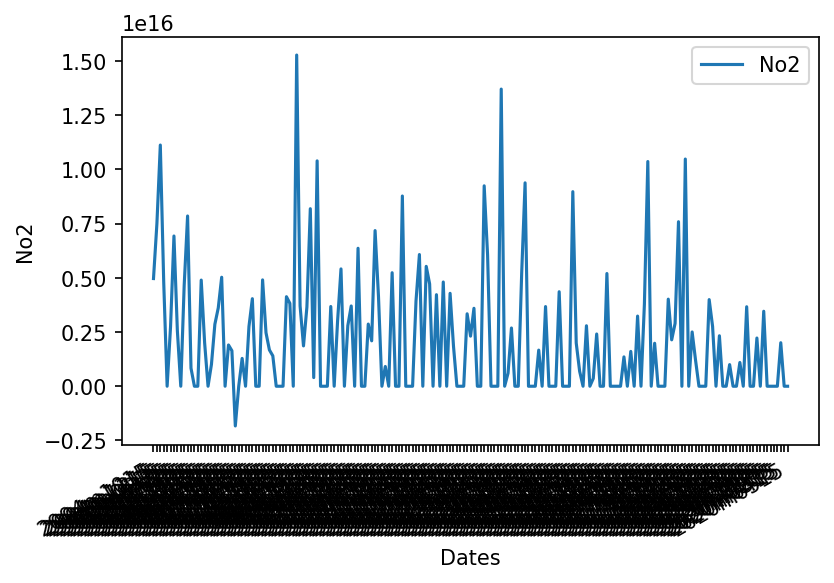

In [215]:
with futures.ThreadPoolExecutor(max_workers=10) as executor:
    future_work = [
        executor.submit(fetch_bbox, file) for file in files_15
    ]

    for f in tqdm(futures.as_completed(future_work), total=len(future_work)):               
        pass

values, dates  = zip(*list(_filter_futures(future_work)))

fig, ax1 = plt.subplots(dpi=150)
fig.autofmt_xdate()

ax1.plot(dates, values, label="No2")

ax1.set_xlabel("Dates")
ax1.set_ylabel("No2")

ax1.legend()

In [211]:
# same for all the days for the last 16 years

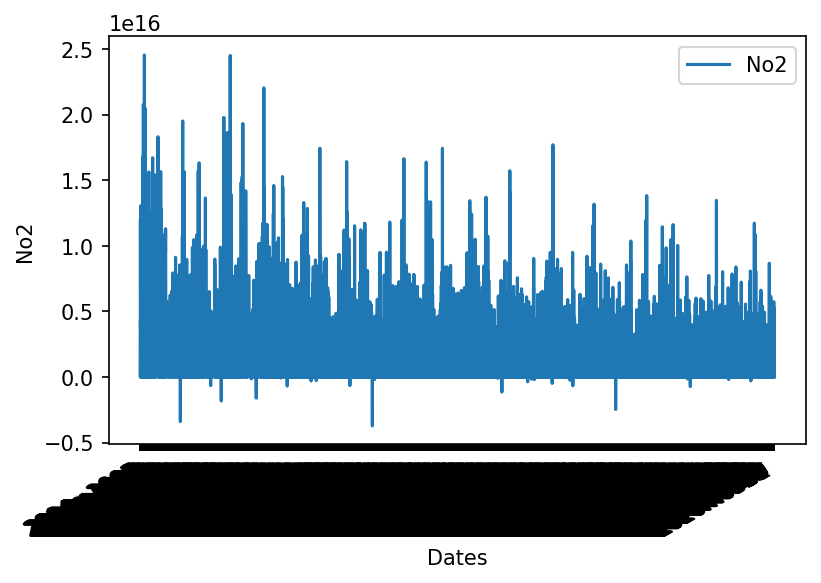

In [210]:
with futures.ThreadPoolExecutor(max_workers=50) as executor:
    future_work = [
        executor.submit(fetch_bbox, file) for file in files
    ]

    for f in tqdm(futures.as_completed(future_work), total=len(future_work)):               
        pass

values, dates  = zip(*list(_filter_futures(future_work)))

fig, ax1 = plt.subplots(dpi=150)
fig.autofmt_xdate()

ax1.plot(dates, values, label="No2")

ax1.set_xlabel("Dates")
ax1.set_ylabel("No2")

ax1.legend()